In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sym
import statsmodels.api as sm
from scipy.optimize import fsolve
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import copulas

from copulas.univariate import BetaUnivariate, GaussianKDE, GaussianUnivariate, GammaUnivariate, StudentTUnivariate
from copulas.multivariate import GaussianMultivariate
from scipy.stats import t, pearsonr
import statsmodels.api as sm
import scipy as sp

### Data cleaning

In [3]:
# import csv
bid_ask_0 = pd.read_csv("./island-data-bottle-round-2/prices_round_2_day_-1.csv", sep=";")
bid_ask_1 = pd.read_csv("./island-data-bottle-round-2/prices_round_2_day_0.csv", sep=";")
bid_ask_2 = pd.read_csv("./island-data-bottle-round-2/prices_round_2_day_1.csv", sep=";")

In [4]:
deal_0 = pd.read_csv("./island-data-bottle-round-2/trades_round_2_day_-1_nn.csv", sep=";")
deal_1 = pd.read_csv("./island-data-bottle-round-2/trades_round_2_day_0_nn.csv", sep=";")
deal_2 = pd.read_csv("./island-data-bottle-round-2/trades_round_2_day_1_nn.csv", sep=";")

### MACD

In [87]:
# extract banana, day -1, day 0 as train
banana = pd.concat([bid_ask_0[bid_ask_0['product'] == 'BANANAS'], 
                    bid_ask_1[bid_ask_1['product'] == 'BANANAS'],
                    bid_ask_2[bid_ask_2['product'] == 'BANANAS']], axis = 0)

In [88]:
banana = banana.reset_index(drop = True)

In [89]:
# compute mid price
banana['mid'] = (banana['bid_price_1'] + banana['ask_price_1'])/2

# compute return
banana['returns'] = banana['mid'].pct_change()

In [90]:
# compute EMA12
banana['EMA12'] = banana['mid'].ewm(span=12, adjust=False).mean()

# compute EMA 
banana['EMA26'] = banana['mid'].ewm(span=26, adjust=False).mean()

# compute MACD
banana['MACD'] = banana['EMA12'] - banana['EMA26']

#compute MACD 9
banana['MACD9'] = banana['MACD'].ewm(span=9, adjust=False).mean()

# diff
banana['MACD_diff'] = banana['MACD'] - banana['MACD9']

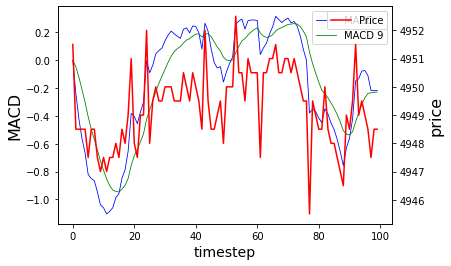

In [91]:
fig,ax = plt.subplots()

#add first line to plot
ax.plot(banana['MACD'][:100], color = 'blue', linewidth = 0.8)
ax.plot(banana['MACD9'][:100], color = 'green', linewidth = 0.8)
#add x-axis label
ax.set_xlabel('timestep', fontsize=14)

#add y-axis label
ax.set_ylabel('MACD',fontsize=16)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()

#add second line to plot
ax2.plot(banana['mid'][:100], color = 'red')

#add second y-axis label
ax2.set_ylabel('price', fontsize=16)

ax.legend(['MACD', 'MACD 9'])
ax2.legend(['Price'])

#plt.title('Cumulative Return vs. Norm Price with 90% CI')
#plt.savefig('cum_ret_vs_norm_price_90.png', dpi=960)

In [92]:
# RSI
banana['U'] = banana['mid'] - banana['mid'].shift(1)
banana['D'] = banana['mid'].shift(1) - banana['mid']

banana['U'] = banana['U'].apply(lambda x: max(0, x))
banana['D'] = banana['D'].apply(lambda x: max(0, x))

# compute RS
banana['RS'] = banana['U'].ewm(span=12, adjust=False).mean() / banana['D'].ewm(span=12, adjust=False).mean()

# compute RSI
banana['RSI'] = 100 - (100 / (1 + banana['RS']))

In [107]:
# 
banana['MACD_sig'] = banana['MACD_diff'].map(lambda x: 1 if x > 0 else -1).shift(1)
banana['RSI_sig'] = banana['RSI'].map(lambda x: 1 if x < 50 else -1).shift(1)
banana['signal'] = np.where(banana.MACD_sig == banana.RSI_sig, banana.MACD_sig, 0)
banana['return$'] = banana['signal'] * banana['returns']
banana['return_cum'] = (1 + banana['return$']).cumprod()

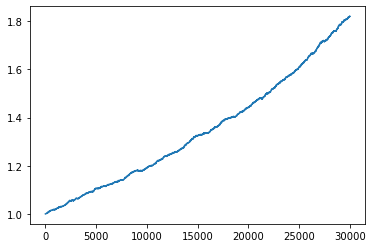

In [108]:
plt.plot(banana['return_cum'])